In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
from scipy.interpolate import interp1d
from scipy.integrate import quad
import random

using vice version  1.4.0.dev1


In [3]:
from surp.analysis.vice_model import vice_model
from surp.analysis import apogee_analysis as aah
import seaborn as sns
import arya


In [4]:
fiducial = vice_model("../out/C11_f0.2_beta0.001.json")

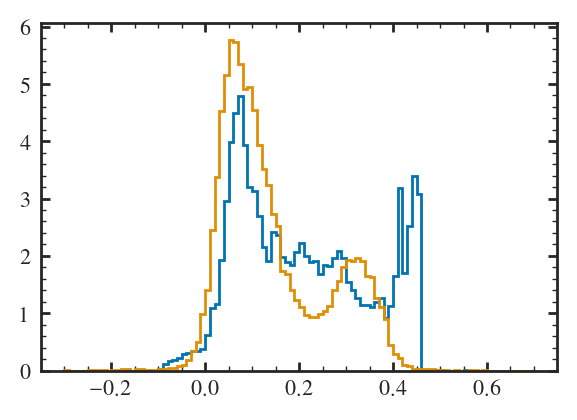

In [14]:
df = fiducial.history

plt.hist(df["[o/fe]"], 100, histtype="step", density=True, range=(-0.3, 0.7))
plt.hist(aah.subgiants["MG_FE"], 100, histtype="step", density=True, range=(-0.3, 0.7));

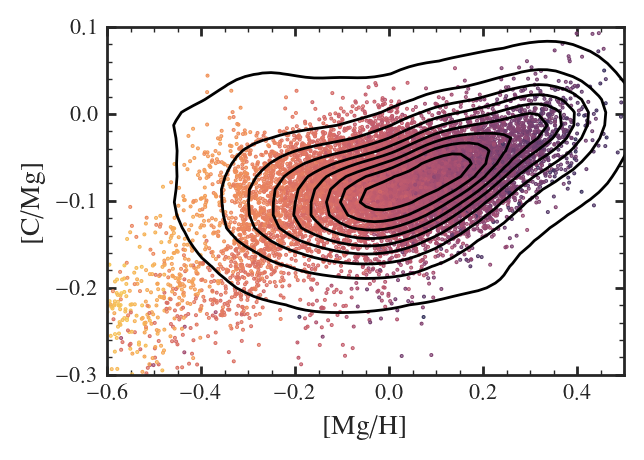

In [111]:
s = fiducial.stars
N = len(s)
dx = 0.03
dy = 0.03
aah.plot_contour("[mg/h]", "[c/mg]", zorder=3)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[c/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.3, 0.1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("fiducial_scatter.pdf")

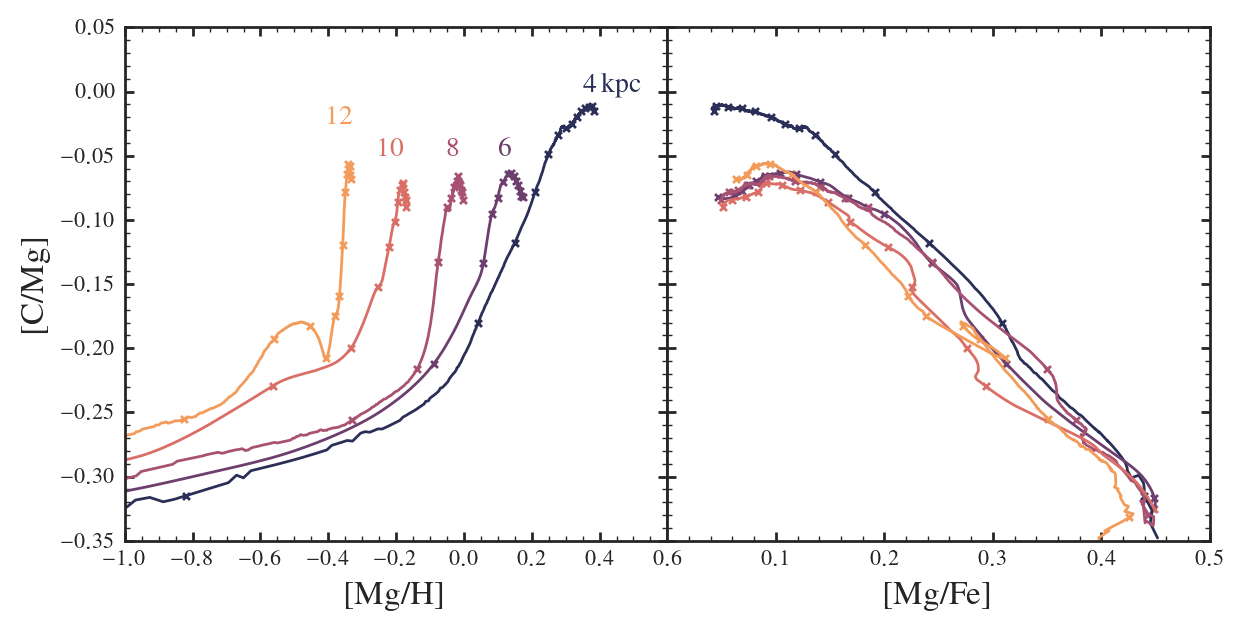

In [5]:

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_R_slices("[mg/h]", "[c/mg]", legend=False)

colors = plt.get_cmap()(np.linspace(0.8, 0, 5))

coords = [
    (-0.4, -0.025),
    (-0.25, -0.05),
    (-0.05, -0.05),
    (0.1, -0.05),
    (0.35, 0.0)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]
for i in range(5):
    plt.text(*coords[i], texts[i], color=colors[i])

plt.xlabel(r"[Mg/H]")
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)
plt.ylim(-0.35, 0.05)


plt.sca(axs[1])
fiducial.plot_R_slices("[mg/fe]", "[c/mg]", legend=False)

plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(0, 0.5)
plt.ylim(-0.35, 0.05)
plt.xticks(np.arange(0.1, 0.6, 0.1))

plt.savefig("evo_tracks.pdf")

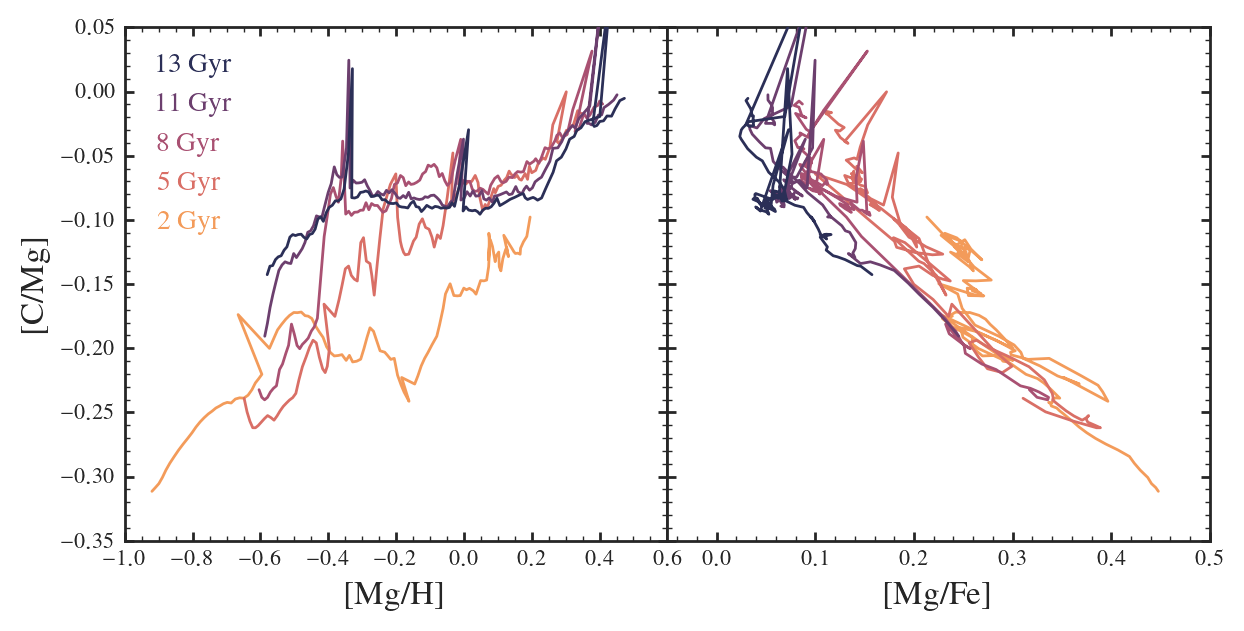

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_t_slices("[mg/h]", "[c/mg]")




plt.xlabel(r"[Mg/H]")
plt.ylim(-0.35, 0.05)
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)

plt.sca(axs[1])


fiducial.plot_t_slices("[mg/fe]", "[c/mg]",legend=False)



plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(-0.05, 0.5)

plt.savefig("evo_slices.pdf")

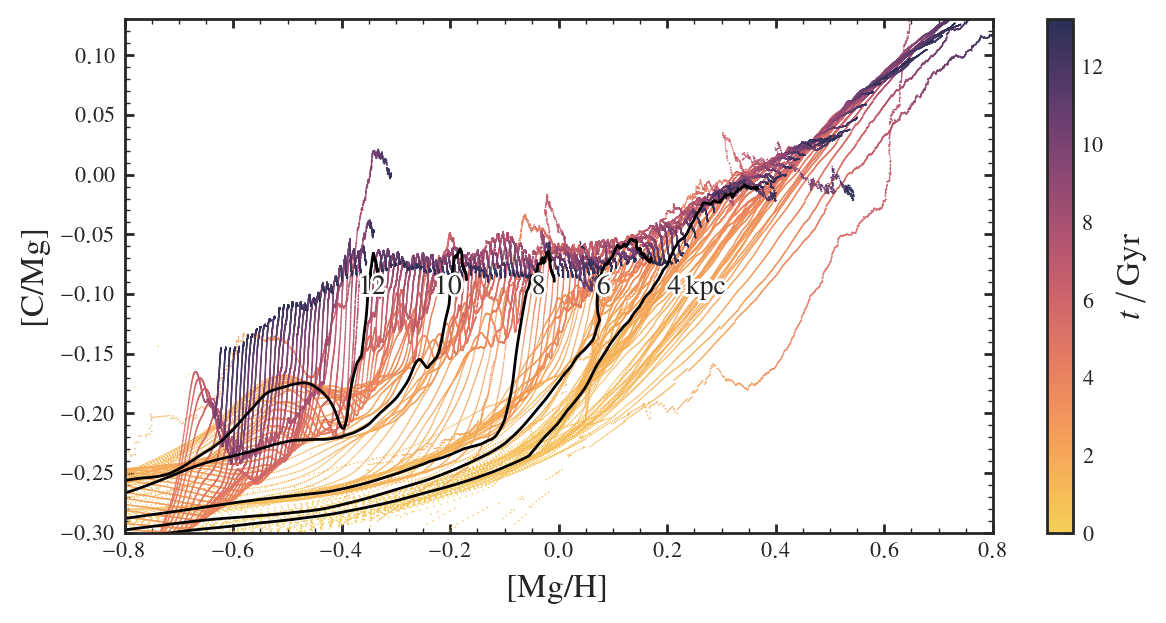

In [29]:
plt.figure(figsize=(7, 10/3))
h = fiducial.history

for R in [4, 6, 8, 10, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df["[o/h]"], df["[c/o]"], color="k")

    
    
coords = [
    (-0.37, -0.1),
    (-0.23, -0.1),
    (-0.05, -0.1),
    (0.07, -0.1),
    (0.2, -0.1)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(5):
    text = plt.text(*coords[i], texts[i])
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=2, foreground='w'),
                   mpl.patheffects.Normal()])

sns.scatterplot(h, x="[o/h]", y="[c/o]", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r")
plt.xlim(-0.8, 0.8)
plt.ylim(-0.3, 0.13)
arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("all_the_tracks.pdf")

(-0.3, 0.13)

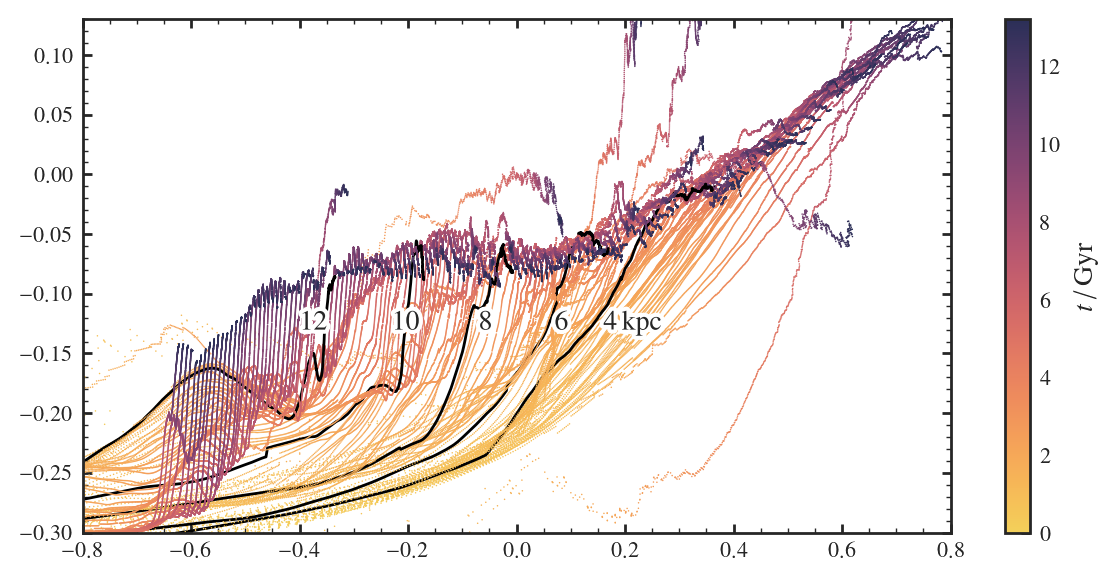

In [36]:
plt.figure(figsize=(7, 10/3))


h = fiducial.history
cb = arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")

for R in np.sort(h.R.unique()):
    dfa = h[h.R == R]
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        plt.plot(dfa["[o/h]"], dfa["[c/o]"], lw=1, c="k", zorder=1)
    else:
        plt.scatter(dfa["[o/h]"], dfa["[c/o]"], s=0.3, c=cb(dfa.time), ec="none", zorder=1)
    
coords = [
    (-0.4, -0.13),
    (-0.23, -0.13),
    (-0.07, -0.13),
    (0.07, -0.13),
    (0.16, -0.13)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(5):
    text = plt.text(*coords[i], texts[i])
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                   mpl.patheffects.Normal()])
    
plt.xlim(-0.8, 0.8)
plt.ylim(-0.3, 0.13)

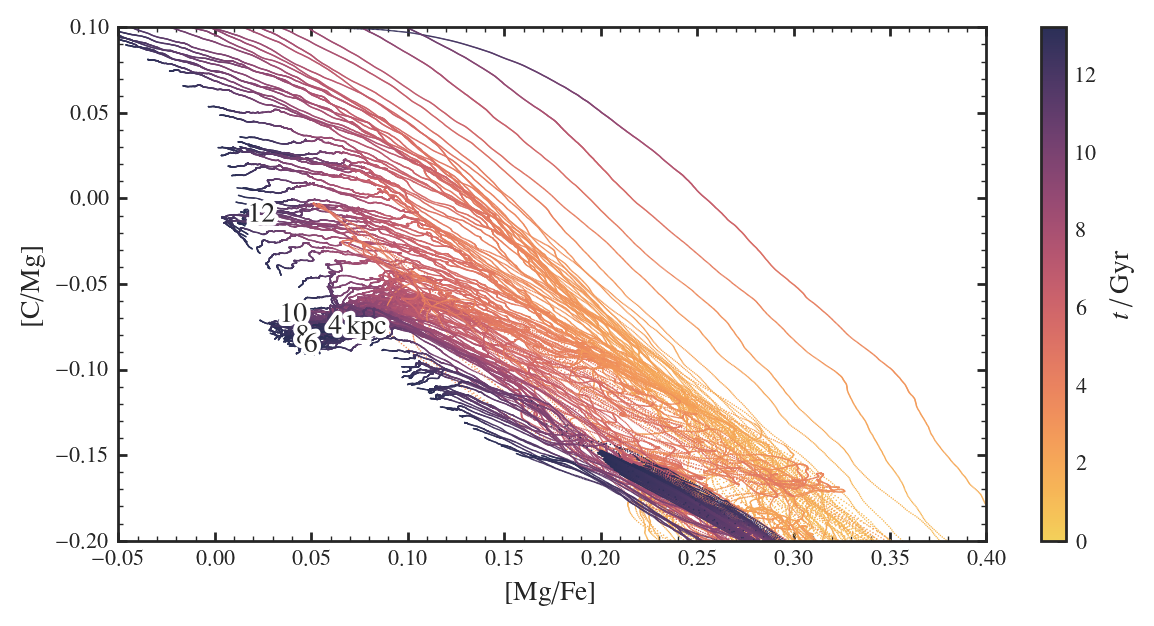

In [6]:
plt.figure(figsize=(7, 10/3))


filt = fiducial.history["[o/h]"] > -0.15
filt &= fiducial.history["[o/h]"] < -0.05
h = fiducial.history
cb = arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")

coords = []

for R in np.sort(h.R.unique()):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], c=cb(dfa.time), s=0.3, ec="none")
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        coords.append((
            dfa["[o/fe]"][-1], 
            dfa["[c/o]"][-1]
        ))

        # plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], s=0.3, c=cb(dfa.time), ec="none", zorder=1)
    

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(len(coords)):
    text = plt.text(*coords[i], texts[i], zorder=20)
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                   mpl.patheffects.Normal()])
    
plt.xlim(-0.05, 0.4)
plt.ylim(-0.2, 0.1)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.savefig("coofe_tracks.pdf")